In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
from scipy.stats import norm
from atlasreader import create_output
import sklearn

import nilearn
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, math_img, threshold_img, concat_imgs, mean_img
from nilearn import plotting
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



# Looking at one participant

In [2]:
# Loading searchlight analysis results from a pickle file
f = open('../FaceWordData/WordFace_searchlight_1.pkl', 'rb')
searchlight = pickle.load(f)
f.close()
print(searchlight)  # Displaying the loaded searchlight object

SearchLight(cv=10, estimator=LinearSVC(dual='auto', max_iter=2000),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f626ed97640>,
            n_jobs=-1,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f610f156cb0>,
            radius=5, verbose=10)


/work/neuro_5/neuro_env/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# Setting a file path for a brain mask and creating a new image based on searchlight scores
mask_wb_filename='../FaceWordData/BIDS/derivatives/sub-0054/anat/sub-0054_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
searchlight_img = new_img_like(mask_wb_filename, searchlight.scores_)
print(searchlight_img.shape)  # Displaying the shape of the created searchlight image


(193, 235, 198)


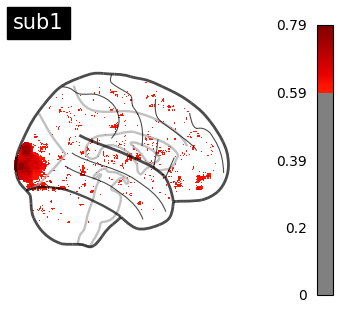

In [4]:
# Plotting a glass brain representation of the searchlight image
plot_glass_brain(searchlight_img, cmap='jet', colorbar=True, threshold=0.6,
                              title=('sub1'), plot_abs=False, display_mode='x')
plt.show()  # Displaying the glass brain plot

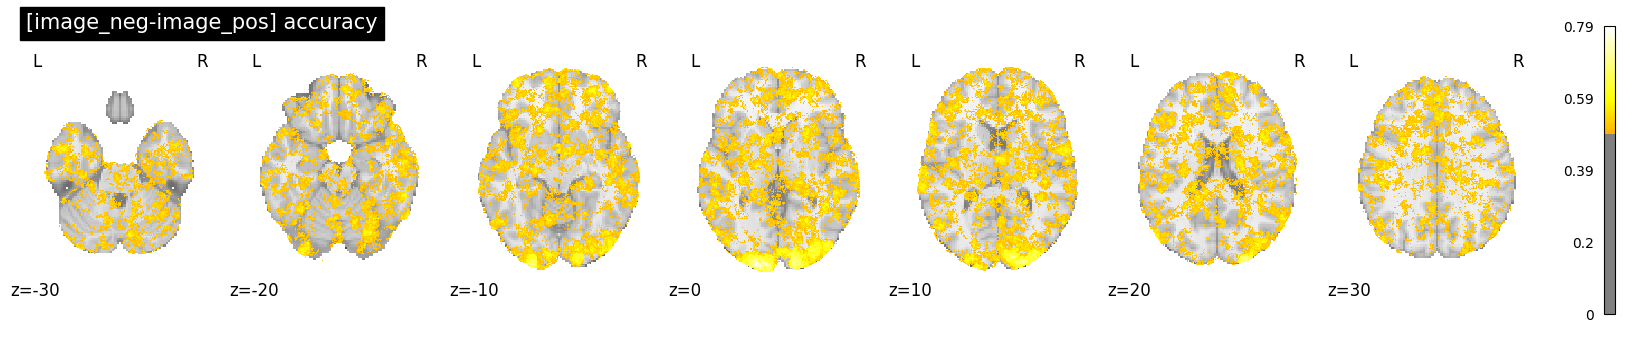

In [5]:
# Plotting a statistical map of the searchlight image with specific parameters
plot_stat_map(searchlight_img, cmap='cold_hot', threshold=0.5, cut_coords=[-30, -20, -10, 0, 10, 20, 30],
              display_mode='z', black_bg=False, title='[image_neg-image_pos] accuracy')
plt.show()  # Displaying the statistical map plot

In [6]:
del searchlight
del searchlight_img
del mask_wb_filename

# Looking at everyone

In [7]:
# Hoping this is universal for every participant?
mask_wb_filename='../FaceWordData/BIDS/derivatives/sub-0054/anat/sub-0054_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

# Preparing to load multiple searchlight results for a number of participants
N_par = 21
searchlight_all = np.empty((N_par, 0)).tolist()  # Initializing an empty list for all participants
searchlight_all = []  # Resetting the list for all participants
searchlight_demean = []  # Initializing a list for demeaned searchlight images
conditions_label_all = np.empty((N_par, 0)).tolist()  # Initializing a list for condition labels


# Iterating over participants, loading and processing their searchlight results
for i in range(0, N_par):
    text = "Loading file %d\n" % (i + 1)
    print(text)  # Printing the status of file loading
    file_name = '../FaceWordData/WordFace_searchlight_' + str(i) + '.pkl'
    f = open(file_name, 'rb')
    searchlight = pickle.load(f)
    searchlight_img = new_img_like(mask_wb_filename, searchlight.scores_)  # Creating a new image from scores
    searchlight_all.append(searchlight_img)  # Appending the new image to the list
    # Demeaning the searchlight image and applying a mask
    # Chance level is 0.5, substracting this shows how much better it is than the mean
    searchlight_demean.append(math_img("(img1 - 0.5) * img2", img1=searchlight_img, img2=mask_wb_filename))
    f.close()  # Closing the file

print(searchlight_all[1])  # Displaying the second searchlight image in the list


Loading file 1



/work/neuro_5/neuro_env/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading file 2

Loading file 3

Loading file 4

Loading file 5

Loading file 6

Loading file 7

Loading file 8

Loading file 9

Loading file 10

Loading file 11

Loading file 12

Loading file 13

Loading file 14

Loading file 15

Loading file 16

Loading file 17

Loading file 18

Loading file 19

Loading file 20

Loading file 21


<class 'nibabel.nifti1.Nifti1Image'>
data shape (193, 235, 198)
affine:
[[   1.       0.       0.     -96.   ]
 [   0.       0.977    0.    -132.   ]
 [   0.       0.       0.977  -78.   ]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 193 235 198   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim         

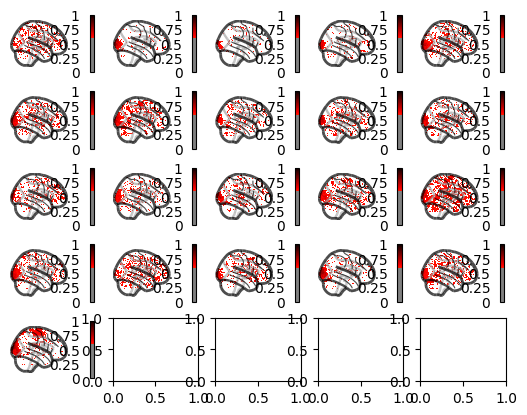

<Figure size 640x480 with 0 Axes>

In [8]:
# Preparation for plotting a grid of glass brain images
fig, axes = plt.subplots(nrows=5, ncols=5)  # Creating a grid of subplots with 5 rows and 5 columns

# Iterating over the searchlight images and plotting each as a glass brain in the subplot grid
for cidx, map in enumerate(searchlight_all):
    plotting.plot_glass_brain(
        map,
        colorbar=True,  # Enabling the colorbar
        threshold=0.6,  # Setting a threshold for the display
        vmin=0.5,  # Setting the minimum value for color mapping
        vmax=1,  # Setting the maximum value for color mapping
        title=None,  # No title for individual plots
        axes=axes[int(cidx / 5), int(cidx % 5)],  # Assigning each plot to a specific position in the grid
        plot_abs=False,  # Setting plot_abs to False
        display_mode="x"  # Setting the display mode to 'x' axis
    )
plt.show()  # Displaying the grid of glass brain plots

# save the figure
plt.savefig('../plots/all_searchlight.png', dpi=300)

In [9]:
# Concatenating and averaging searchlight images
searchlight_conc = concat_imgs(searchlight_all)  # Concatenating all searchlight images into one - just a prep to do the mean
searchlight_mean = mean_img(searchlight_conc)  # Calculating the mean of the concatenated images
searchlight_conc_de = concat_imgs(searchlight_demean)  # Concatenating all baseline-corrected searchlight images
searchlight_mean_demean = mean_img(searchlight_conc_de)  # Calculating the mean of the baseline-corrected images

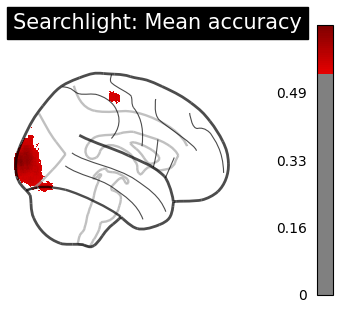

In [10]:
# Plotting the mean of the searchlight images
mean_glass_plot = plot_glass_brain(searchlight_mean, cmap='jet', colorbar=True, threshold=0.55,
                 title=('Searchlight: Mean accuracy'),  # Setting the title for the plot
                 plot_abs=False, display_mode='x')  # Plotting the mean glass brain with specific settings
# Saving the plot as a png file
mean_glass_plot.savefig('../plots/mean_glass_plot.png')

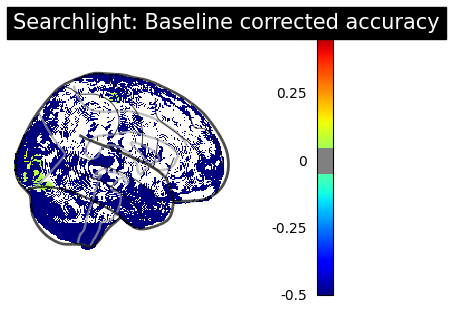

In [11]:
# Plotting the mean of the baseline-corrected searchlight images
baseline_glass_plot = plot_glass_brain(searchlight_mean_demean, cmap='jet', colorbar=True, threshold=0.05, vmin=0,
                 title=('Searchlight: Baseline corrected accuracy'),  # Setting the title for this plot
                 plot_abs=False, display_mode='x')  # Plotting the baseline-corrected mean glass brain
# Saving the plot as a png file
baseline_glass_plot.savefig('../plots/baseline_glass_plot.png')

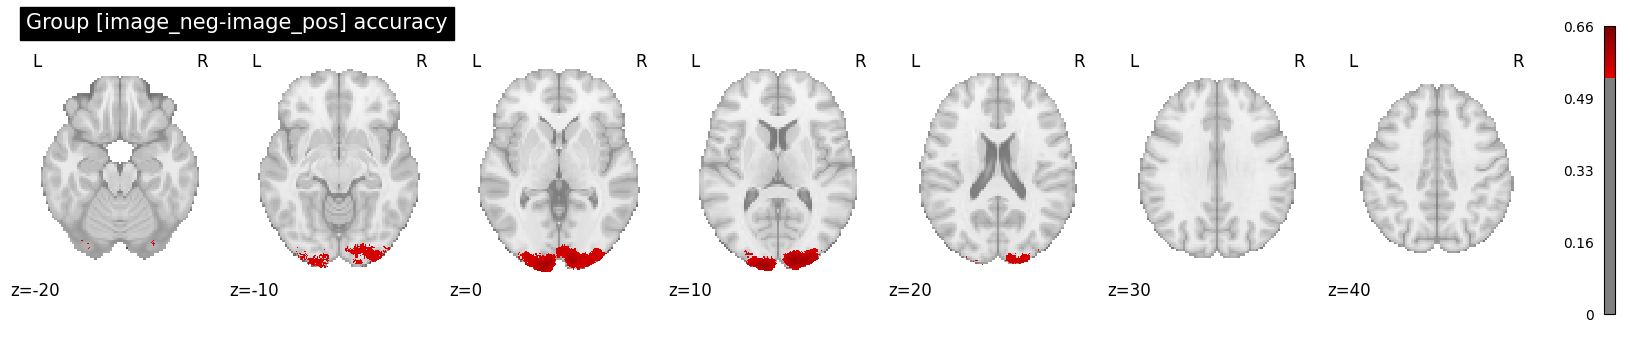

<Figure size 640x480 with 0 Axes>

In [12]:
# Plotting a statistical map of the mean searchlight image
plot_stat_map(searchlight_mean, cmap='jet', threshold=0.55, cut_coords=[-20, -10, 0, 10, 20, 30, 40],
              display_mode='z', black_bg=False,  # Setting display parameters
              title='Group [image_neg-image_pos] accuracy')  # Setting the title for this plot
plt.show()  # Displaying the statistical map plot
# saving the plot as a png file
plt.savefig('../plots/group_stat_map.png', dpi=300)  

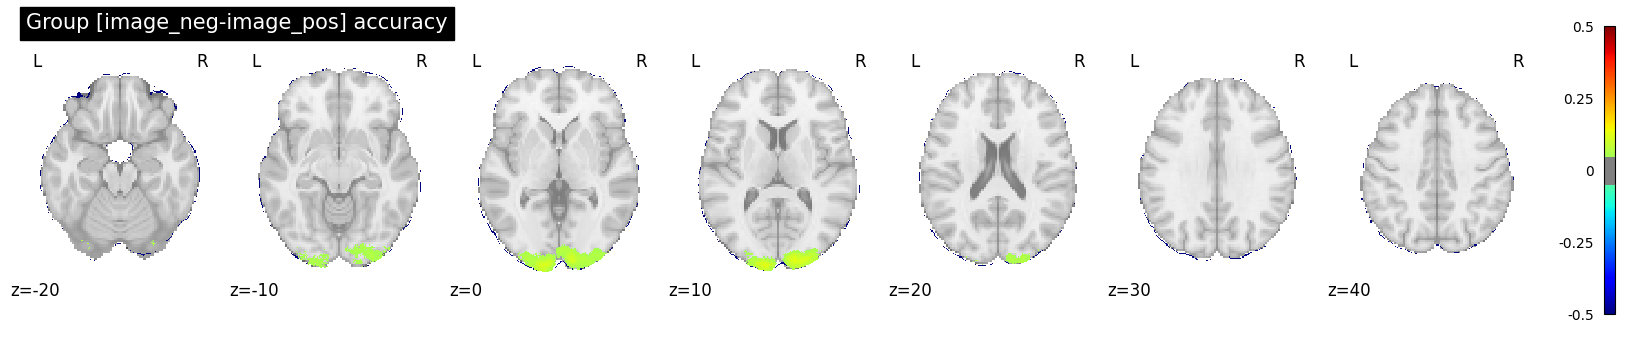

<Figure size 640x480 with 0 Axes>

In [13]:
# Plotting a statistical map for the mean demeaned searchlight image
plot_stat_map(searchlight_mean_demean, cmap='jet', threshold=0.05, cut_coords=[-20, -10, 0, 10, 20, 30, 40],
              display_mode='z', black_bg=False,  # Setting display parameters
              title='Group [image_neg-image_pos] accuracy')  # Setting the title for the plot
plt.show()  # Displaying the statistical map plot
# saving the plot as a png file
plt.savefig('../plots/mean_group_stat_map.png', dpi=300) 

# Group level analysis

In [14]:
# Preparing the second level model analysis
# searchlight_demean is a list of all participants 
second_level_input = searchlight_demean  # Assigning baseline-corrected images as input
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],  # Creating a design matrix with an intercept
)

# Initializing and fitting the second level model
second_level_model = SecondLevelModel(smoothing_fwhm=6.0, n_jobs=2)
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix,
)

# Computing contrast using the second level model
z_map = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

/work/neuro_5/neuro_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:346: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


In [31]:
# Calculating and printing the uncorrected p-value threshold
p_val = .001
p001_unc = norm.isf(p_val)
print(f"The p<0.001 threshold is {p001_unc:.3g}")

# Applying statistical thresholding and printing FDR threshold
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")

# Applying Bonferroni correction and printing the threshold
thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")

# Removing negative effects from the z-map as they are not meaningful
z_map_disp = threshold_img(
    z_map,
    threshold=0,
    two_sided=False,
)

The p<0.001 threshold is 3.09
The FDR=.05 threshold is 2.61
The p<.05 Bonferroni-corrected threshold is 5.57


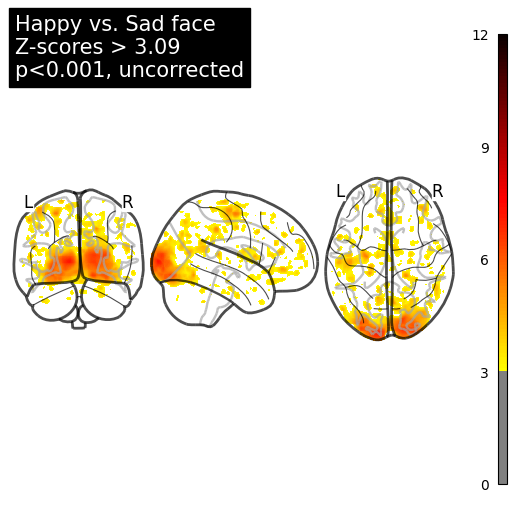

In [40]:
# Displaying glass brain plots with different statistical thresholds
# Plot for uncorrected p-value threshold
display = plotting.plot_glass_brain(
    z_map_disp,
    threshold=p001_unc,
    vmin=0,
    vmax=12,
    colorbar=True,
    symmetric_cbar=False,
    plot_abs=False,
    title=f"Happy vs. Sad face \nZ-scores > {p001_unc:.3g} \np<0.001, uncorrected",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()

# Saving the plot as a png file
display.savefig('../plots/uncor.png') 

# Type 1 error very high here, because we do so many tests

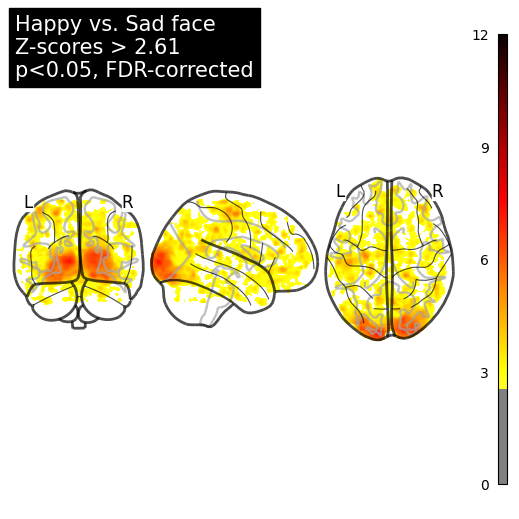

In [39]:
# Plot for FDR-corrected threshold
display = plotting.plot_glass_brain(
    z_map_disp,
    threshold=threshold2,
    vmin=0,
    vmax=12,
    colorbar=True,
    symmetric_cbar=False,
    plot_abs=False,
    title=f"Happy vs. Sad face \nZ-scores > {threshold2:.3g} \np<0.05, FDR-corrected",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()

# Saving the plot as a png file
display.savefig('../plots/FDR.png') 

ValueError: 'gist_heart' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'black_blue', 'black_blue_r', 'black_green', 'black_green_r', 'black_pink', 'black_pink_r', 'black_purple', 'black_purple_r', 'black_red', 'black_red_r', 'blue_orange', 'blue_orange_r', 'blue_red', 'blue_red_r', 'blue_transparent', 'blue_transparent_full_alpha_range', 'bone', 'bone_r', 'brg', 'brg_r', 'brown_blue', 'brown_blue_r', 'brown_cyan', 'brown_cyan_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cold_hot', 'cold_hot_r', 'cold_white_hot', 'cold_white_hot_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'cyan_copper', 'cyan_copper_r', 'cyan_orange', 'cyan_orange_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'green_transparent', 'green_transparent_full_alpha_range', 'hot', 'hot_black_bone', 'hot_black_bone_r', 'hot_r', 'hot_white_bone', 'hot_white_bone_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_hot', 'ocean_hot_r', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'purple_blue', 'purple_blue_r', 'purple_green', 'purple_green_r', 'rainbow', 'rainbow_r', 'red_transparent', 'red_transparent_full_alpha_range', 'roy_big_bl', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'videen_style', 'viridis', 'viridis_r', 'winter', 'winter_r'

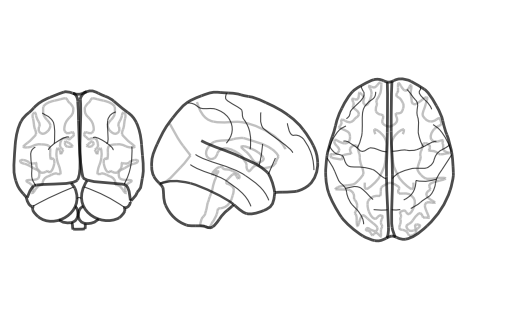

In [55]:
# Plot for Bonferroni-corrected threshold
display = plotting.plot_glass_brain(
    z_map_disp,
    threshold=threshold3,
    vmin=5,
    vmax=8,
    cmap='ni',
    colorbar=True,
    symmetric_cbar=False,
    plot_abs=False,
    title=f"Happy vs. Sad face \nZ-scores > {threshold3:.3g} \np<0.05, bonferroni",
    figure=plt.figure(figsize=(5, 3)),
)
plotting.show()

# Saving the plot as a png file
display.savefig('../plots/bonferroni.png') 

# Dividing the p-value with total number of t-tests (voxels)

In [30]:
# Generating output files using atlasreader for the Bonferroni-corrected map
create_output(z_map_disp, voxel_thresh=threshold3, cluster_extent=1, direction='pos', outdir='../atlasreader')

In [19]:
# Generating output files using atlasreader for the Bonferroni-corrected map
# create_output(thresholded_map3, voxel_thresh=threshold3, cluster_extent=2, direction='pos', outdir='../atlasreader_1')

In [20]:
# Generating output files using atlasreader for the Bonferroni-corrected map
# create_output(z_map_disp, voxel_thresh=threshold3, cluster_extent=2, direction='pos', outdir='../atlasreader_2')

In [22]:
# load csv as dataframe
# atlasreader_1 = pd.read_csv('../atlasreader_1/atlasreader_clusters.csv')
# atlasreader_2 = pd.read_csv('../atlasreader_2/atlasreader_clusters.csv')

# check whether they are identical
# atlasreader_1.equals(atlasreader_2)

True